# MagLev: Introducción a Métodos de diseño de controladores en Espacio de Estados

En el siguiente Notebook de Python, mostraremos cómo diseñar controladores y observadores usando métodos de espacio de estados. [ref#1](#cite1)

Usaremos comando de la bibliotecas control (ss , forced_response , place , acker), numpy (linalg.eigvals,linalg.matrix_rank) y matplotlib.pyplot (plot)

- [Modelado](#id1)
- [Análisis de estabilidad](#id2)
- [Controlabilidad y Observabilidad](#id3)
- [Diseño de una ley de control por realimentación de todos los estados](#id4)
- [Introducción de entrada de referencia](#id5)
- [Diseño del Estimador](#id6)
- [Referencias](#id7)



<a id="id1"></a>
## Modelado

En el siguiente ejemplo se suspende una bola con un electroimán. En este sistema la corriente a través de la bobina induce una fuerza magnética con la que puede balancear la fuerza de gravedad y mantener la bola suspendida en el aire (la bola puede ser de un material magnético o un imán). El modelo del sistema es típico en control motivado por el control de suspensión magnética de trenes.

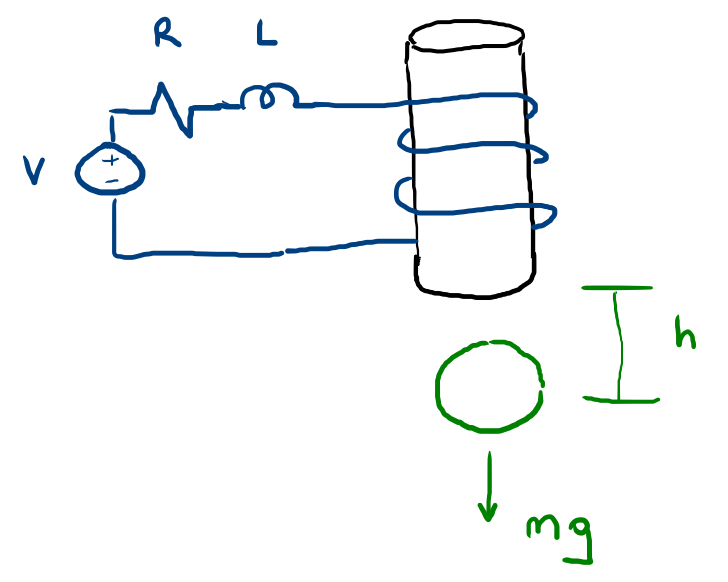

La ecuaciones para el sistema son:

$$
m\frac{d^2h}{dt^2} = mg - \frac{Ki^2}{h}
$$

$$
V = L\frac{di}{dt} + iR
$$

Donde $h$ es la posición vertical de la bola, $i$ es la corriente a través del electroimán, $V$ es la tensión aplicada, $m$ es la masa de la bola, $g$ es la aceleración de la gravedad, $L$ es la inductancia, $R$ es la resistencia, y $K$ es el coeficiente de la fuerza magnética sobre la bolita. Para simplificar, elegiremos los valores de $m$ = 0.05 kg, $K$ = 0.0001, $L$ = 0.01 H, $R$ = 1 Ohm, $g$ = 9.81 m/s^2. El punto de equilibrio elegido es (la bola es suspendida en el aire) donde $h$ = $K i^2/mg$ (en este punto $dh/dt$ = 0). En este punto linealizamos las ecuaciones en el punto $h$ = 0.01 m (la corriente nominal es aproximadamente 7 Amps) y obtenemos la linealización de las ecuaciones:

$$
\frac{d\mathbf{x}}{dt} = A\mathbf{x} + Bu
$$

$$
y = C\mathbf{x} + Du
$$

donde:

$$
x =
\left[{\begin{array}{c}
  \Delta h \\ \Delta \dot{h} \\ \Delta i
\end{array}}\right]
$$

es el conjunto de variables de estados del sistema (un vector de 3x1), $u$ es la desviación del voltaje sobre el valor de su punto de equilibrio ($\Delta V$), y $y$ (la salida) es la desviación sobre el punto de equilibrio para la posición de la bola ($\Delta h$).

Por desarrollos teóricos, ver el apunte de Gonzalo Molina [ref#2](#cite2):

In [1]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
A = [ [0,   1,   0],
      [980,  0,  -2.8],
      [0,   0,  -100] ];

B = [ [0],
      [0],
      [100] ];

C = [ 1, 0, 0 ];

<a id="id2"></a>
## Análisis de estabilidad
El primer paso es analizar el sistema a lazo abierto, verificar el modelo y la estabilidad del sistema. Para determinar la estabilidad podemos ver los autovalores de la matriz, $A$, que es igual a ver los polos de la función de transferencia del sistema. Los auto valore de la matriz $A$ son los valores de $s$ que son solución de  $\det(sI - A) = 0$.

In [3]:
poles = np.linalg.eigvals(A)
print(poles)

[  31.30495168  -31.30495168 -100.        ]


Por inspección, se puede ver que hay polos en $\mathbb{C}^+$ (semiplano derecho), esto significa que a lazo abierto el sistema es inestable. Adicionalmente, desde el punto de vista de limitaciones de performance el polo en $\mathbb{C}^+$ obliga a que la frecuencia de corte del sistema sea al menos $\omega_c=2*p$ [ref#3.](#cite3) Para observar la inestabilidad del sistema la siguiente simulación nos permite verificar la evolución del sistema:

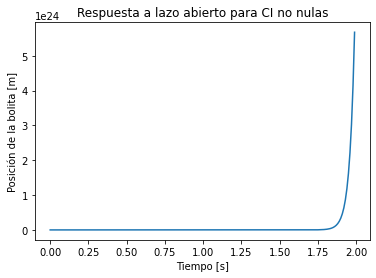

In [4]:
t = np.arange(0,2,0.01)
u = np.zeros(t.size)
x0 = [0.01, 0, 0]

sys = ctrl.ss(A,B,C,0);

t,y,x = ctrl.forced_response(sys,U=u,T=t,X0=x0,return_x=True);
plt.plot(t,y)
plt.title('Respuesta a lazo abierto para CI no nulas')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición de la bolita [m]');

De la gráfica se observa que la posición de la bolita diverge, físicamente esto no sucede, lo que veríamos en realidad es que se pega al electroimán o a la mesa.

<a id="id3"></a>
## Controlabilidad y Observabilidad

Un sistema es controlable si siempre existe una entrada de control, $u(t)$, que pueda pasar de cualquier estado del sistema a cualquier otro estado en tiempo finito. Los sistemas LTI son controlables si su matriz de controlabilidad, $\mathcal{C}$, es de rango completo (p.e. si rank($\mathcal{C}$) = n donde n es el número de variables de estado). Usando Python el rango de la matriz de controlabilidad lo podemos hallar con en comando `np.linalg.matrix_rank(ctrl.ctrb(A,B))` usando los paquetes de numpy (np) y control (ctrl).

$$
\mathcal{C} = [B\ AB\ A^2B\ \cdots \ A^{n-1}B]
$$

Si alguna de las variables de estado no se miden directamente. En este caso es necesario estimar el valor de los estados internos usando las salidas disponibles del sistema. Un sistema es observable si el estado inicial, $x(t_0)$, puede ser determinado a partir de conocer el valor de las entradas del sistema, $u(t)$, y de las salidas, $y(t)$, en un tiempo finito $t_0 < t < t_f$. Para sistemas LTI, el sistema es observable si y sólo si la matriz de observabilidad, $\mathcal{O}$, es de rango completo (p.e. si rank($\mathcal{O}$) = n donde n es el número de variables de estado). La observabilidad de sistema LTI se puede determinar usando las funciones de Python `np.linalg.matrix_rank(ctrl.obsv(A,C))` usando los paquetes de numpy (np) y control (ctrl).

$$
\mathcal{O} = \left[ \begin{array}{c} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{array} \right]
$$

Controlabilidad y observabilidad es un concepto dual. Un sistema ($A$, $B$) es controlable si y sólo si un sistema ($A'$, $C'$) es observable. Este hecho puede ser útil cuando diseñemos un observador, como se muestra abajo.

In [5]:
m_ctrb = ctrl.ctrb(A,B)
rango_ctrb = np.linalg.matrix_rank(m_ctrb)

m_obsv = ctrl.obsv(A,C)
rango_obsv = np.linalg.matrix_rank(m_obsv)

print("Rango la matriz de controlabilidad:",rango_ctrb)
print("Rango la matriz de observabilidad:",rango_obsv)

Rango la matriz de controlabilidad: 3
Rango la matriz de observabilidad: 3


<a id="id4"></a>
## Diseño de una ley de control por realimentación de todos los estados

Vamos a construir un controlador para el sistema usando ubicación de polos. En la siguiente figura se ve la realimentación de todos los estados. Esto significa que todos los estados son conocidos por el controlador a todo tiempo. Para este sistema, nosotros necesitamos un sensor para medir la posición de la bolita, otro para medir la velocidad de la bolita y un tercer sensor para medir la corriente del electroimán.

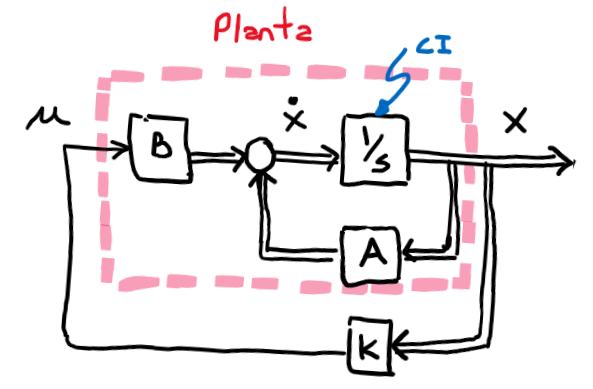

Por simplicidad, asumimos que la referencia es cero, $r$ = 0. La entrada es entonces

$$
u = -K\mathbf{x}
$$

Las ecuaciones de estado a lazo cerrado realimentado son,

$$
\dot{\mathbf{x}} = A\mathbf{x} + B(-K\mathbf{x}) = (A-BK)\mathbf{x}
$$

$$
y = C\mathbf{x}
$$

La estabilidad y la performance en el dominio temporal del sistema realimentado a lazo cerrado se determina por la ubicación de los autovalores de la matriz ($A-BK$), que son los polos a lazo cerrado. Como las matrices $A$ y $BK$ son ambas de 3x3, entonces son 3 los polos del sistema. Por elegir una apropiada matriz de ganancias de realimentación $K$, nosotros podemos ubicar los polos a lazo cerrado en cualquier lugar deseado (porque el sistema es totalmente controlable). Podemos usar la función `place` para encontrar las ganancias de realimentación, $K$, que provee polos en la ubicación deseada.

Ahora vamos a decidir dónde ponemos los polos a lazo cerrado. Supongamos el criterio para el controlado donde el tiempo de (settling time) < 0.5 sec y sobrepico (overshoot) < 5%, entonces vamos a ubicar dos polos en -10 +/- 10i (a $\zeta$ = 0.7 o 45 grados con $\sigma$ = 10 > 4.6*2). El tercer polo lo ubicamos a -50 para comenzar (si es lo suficientemente rápido no debe afectar la respuesta temporal del sistema), y podremos cambiarlo en función de qué tanto influye el comportamiento del sistema a lazo cerrado.

Diseñamos el sistema, verificamos el diseño y luego simulamos la respuesta para verificar la respuesta del sistema a lazo cerrado:

In [6]:
p1 = -10 + 10j;
p2 = -10 - 10j;
p3 = -50;
p_obj1= [p1, p2, p3]

K1 = ctrl.place(A,B,p_obj1);
sys_cl1 = ctrl.ss(A-B*K1,B,C,0);

sys_cl1.pole()

array([-10.+10.j, -10.-10.j, -50. +0.j])

Text(0, 0.5, 'Ball Position (m)')

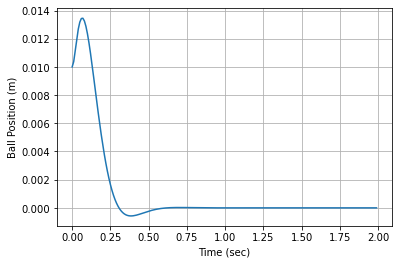

In [7]:
t1,y1,x1 =ctrl.forced_response(sys_cl1,U=u,T=t,X0=x0,return_x=True)
plt.plot(t1,y1)
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Ball Position (m)')

Analicemos la respuesta, qué estamos viendo?.La simulación es lo siguiente, ponemos la bolita 0,01m más abajo de la posición de equilibrio (recordar que h >0 es para abajo), en el instante t=0 la fuerza magnética sobre la bolita es la fuerza en la posición de equilibrio. Cómo la dinámica es lenta (más lenta que la limitación de performance qué impone el polo en $\mathbb{C}^+$) la bolita se cae hasta 0.014m porque la acción de control no es lo suficientemente rápida, pero finalmente logra volver a la posición de equilibrio. Puede ser interesante ver qué pasa con la acción de control u para esta condición, también deberíamos analizar la función de lazo para ver la forma de L(s). 

Trataremos de ubicar los polos más a la izquierda para ver si mejora el transitorio (Esto debería hacer el sistema más rápido). Para esto vamos a contemplar la limitación de performance del sistema, $\omega_c=2*p$, donde $p$ es el polo en $\mathbb{C}^+$, partiremos de considerar que $\omega_n=\omega_c$. El tercer polo lo elegimos cuatro veces más rápido:

In [8]:
wn=63
xi=0.7
sigma=wn*xi
wd=wn*np.sqrt(1-xi**2)

p1 = -sigma + wd*1j
p2 = -sigma - wd*1j
p3 = -4*sigma

p_obj2=[p1, p2, p3]

p_obj2

[(-44.099999999999994+44.99099909981995j),
 (-44.099999999999994-44.99099909981995j),
 -176.39999999999998]

Verificamos que los polos objetivos cumplen con $\omega_n > 63rad/s$

In [9]:
np.abs(p_obj2)

array([ 63. ,  63. , 176.4])

Ahora estamos en condiciones de calcular la ley de control por realimentación de estados 

In [10]:
K2 = ctrl.place(A,B,p_obj2);
sys_cl2 = ctrl.ss(A-B*K2,B,C,0);
K2

array([[-3.42657e+03, -7.32410e+01,  1.64600e+00]])

Primero verificamos lo trivial, que los polos a lazo cerrado estén en el punto que corresponde

In [11]:
sys_cl2.pole()

array([ -44.1+44.9909991j,  -44.1-44.9909991j, -176.4 +0.j       ])

Ahora estamos en condiciones de simular la respuesta del sistema compensado

Text(0, 0.5, 'Ball Position (m)')

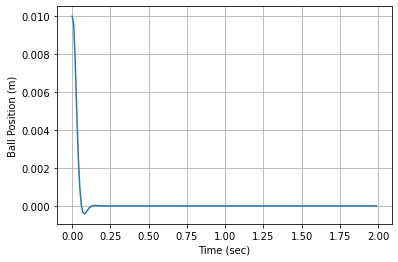

In [12]:
t2,y2,x2 =ctrl.forced_response(sys_cl2,U=u,T=t,X0=x0,return_x=True)

plt.plot(t2,y2)
plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Ball Position (m)')

Comparemos la respuesta y el esfuerzo de control para los dos sistemas $u=-K*x$, ya que cuento con $x$ para los dos casos, podemos graficar rápidamente. Es importante notar que hacer que el sistema sea más rápido requiere que el esfuerzo de control sea mayor:

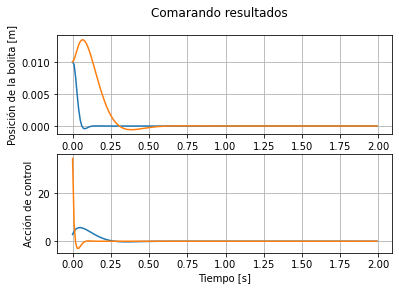

In [13]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Comarando resultados')

ax1.plot(t2,y2,t1,y1)
ax1.grid()
ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('Posición de la bolita [m]')

ax2.plot(t1,-K1[0,:]@x1,t2,-K2[0,:]@x2)
ax2.grid()
ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('Acción de control');


**Nota:** Si desean ubicar dos o más polos en la misma posición, la función `place` no va a funcionar. Pueden usar la función `acker` que permite obtener los mismos resultados (pero el cálculo puede tener problemas numéricos)

`K = acker(A,B,[p1, p2, p3]) o K = acker(A,B,p_obj)`

<a id="id5"></a>
## Introducción de entrada de referencia

Ahora, aplicaremos un escalón de entrada de referencia al sistema a lazo cerrado (un escalón pequeño, para evitar salir que el modelo linealizado pierda validez), tal como se puede ver en la siguiente imagen. 

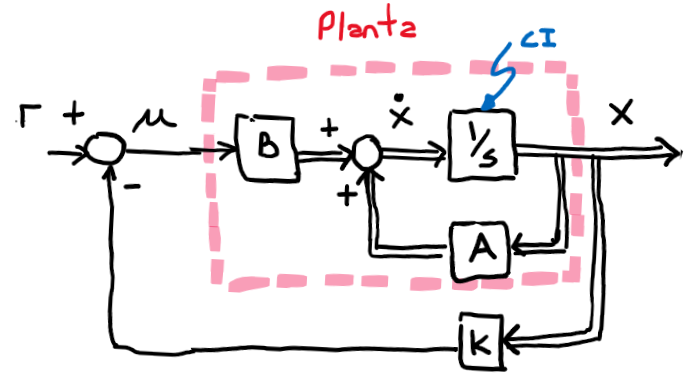

Para esto podemos usar la función `forced_response` o `step_response`:

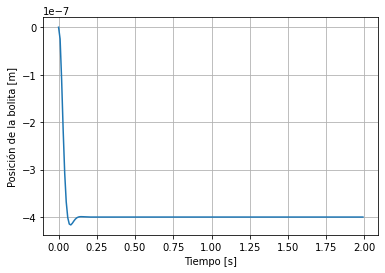

In [14]:
u = 0.001*np.ones(t.size)

sys_cl = ctrl.ss(A-B*K2,B,C,0)

t,y,x =ctrl.forced_response(sys_cl,U=u,T=t,return_x=True)
plt.plot(t,y)
plt.grid()
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición de la bolita [m]');

Es que el sistema sigue el escalón con mucho error, y lo peor, el valor final es negativo en lugar de ir a $r=0.001m$.

En el siguiente esquema, no comparamos la salida con la referencia, porque estamo midiendo todos los estados, y multiplicando por el vector de ganancias $K$, y se lo restamos a la referencia. Normalmente $K\mathbf{x}$ no logra la salida deseada. Para eliminar este problema, simplemente escaleamos la entrada de referencia para hacerlo igual a $K\mathbf{x}$ (Es simplemente un factor fijo, notar que si algo cambia en la planta, el factor probablemente no sea el mismo). El factor, $\overline{N}$, se muestra en la siguiente figura:

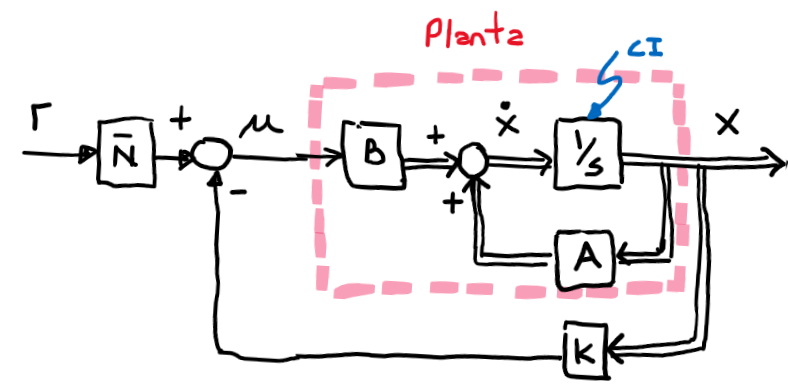

Podemos calcular $\overline{N}$ usando la siguiente función de Python:

In [15]:
def seguimiento_referencia(sys,K):
    '''
     Given the single-input linear system: 
           .
           x = Ax + Bu
           y = Cx + Du
     and the feedback matrix K,this function 
     finds the scale factor N which will 
     eliminate the steady-state error to a step reference 
     for a continuous-time, single-input system
     with full-state feedback using the schematic below:

                          /---------\
      R   /---\   +    u  | .       |        /------\
      --->| N |--->() --->| X=Ax+Bu |=======>| y=Cx |---> y
          \---/   -|      \---------/    |   \------/
                   |         /---\       |  
                   |<--------| K |<======|
                             \---/
    
    '''
    aux1=np.vstack((np.hstack((sys.A,sys.B)),
                   np.hstack((sys.C,sys.D))))
    n=np.shape(sys.A)[0]
    aux2=np.vstack((np.zeros((n,1)),[1]))
    N=np.linalg.inv(aux1)@aux2
    Nx=N[0:n]
    Nu=N[n]
    return (Nu+K@Nx)[0,0]

In [16]:
Nbar = seguimiento_referencia(sys,K2)
print(Nbar)#o simplemente Nbar en la última fila para imprimir el resultado

-2500.4700000000066


Esta función no se encuentra en los paquetes de control. Tendrás que copiar y pegar en tu propio código para ser usada.

Ahora, veremos los resultados en simulación con el $\overline{N}$ incluido, multiplicando la entrada unitaria $u$:

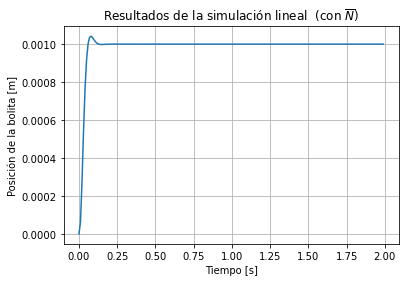

In [17]:
t,y,x =ctrl.forced_response(sys_cl,U=Nbar*u,T=t,return_x=True)

plt.plot(t,y)
plt.grid()
plt.title(r'Resultados de la simulación lineal  (con $\overline{N}$)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición de la bolita [m]');

Otra forma de simular lo anterior es usando la función `step_response` que permite simular la respuesta a un escalón unitario de un sistema determinado; para este caso la entrada de referencia es $r=0.001$ y entra multiplicado por $\overline{N}$:

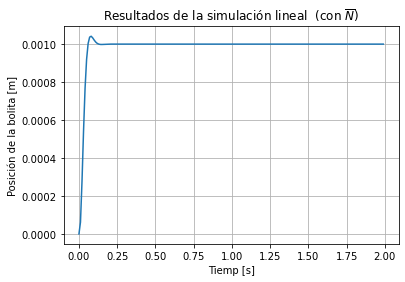

In [18]:
t,y =ctrl.step_response(Nbar*0.001*sys_cl,T=t)

plt.plot(t,y)
plt.grid()
plt.title(r'Resultados de la simulación lineal  (con $\overline{N}$)')
plt.xlabel('Tiemp [s]')
plt.ylabel('Posición de la bolita [m]');

ahora si es posible seguir de forma apropiada la entrada de referencia. Una vez más notar que, el cálculo del factor de escala requiere un muy buen conocimiento del sistema. Variaciones o errores en los parámetro del modelo implican un valor de $\overline{N}$ incorrecto. Para mejora la robustez del sistema se puede diseñar un control integral.

Es posible usar la función `step_info` para obtener información de la respuesta al escalón:

In [19]:
ctrl.step_info(0.001*Nbar*sys_cl)

{'RiseTime': 0.0360268415910632,
 'SettlingTime': 0.10103179489667724,
 'SettlingMin': 0.0009023465248076522,
 'SettlingMax': 0.0010420882808289571,
 'Overshoot': 4.208828082893588,
 'Undershoot': 0,
 'Peak': 0.0010420882808289571,
 'PeakTime': 0.07675283643313464,
 'SteadyStateValue': 0.0010000000000000204}

<a id="id6"></a>
## Diseño del Estimador

No podemos medir todas las variables de estado $\mathbf{x}$ (esto es lo habitual en la práctica), por varias razones, económica (comprar n sensores) y tecnológica (algunas variables son difíciles de medir o no existen sensores para tal medición o la medición es muy ruidosa), podemos construir un observador para estimarlas, mientras solo medimos la salida $y = C\mathbf{x}$. Para este ejemplo, vamos a medir la posición y estimaremos todas las variables de estado del sistema en ($\hat{\mathbf{x}}$). Según se muestra en la siguiente figura:

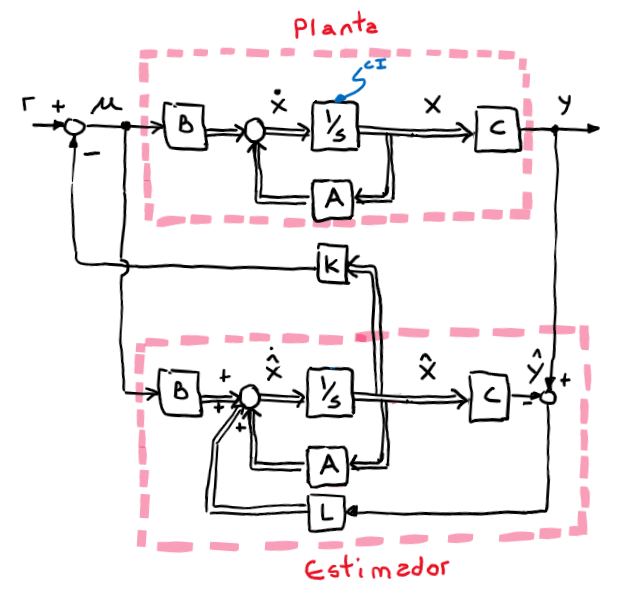


El observador total es básicamente una copia de la planta; tiene la misma entrada y las mismas ecuaciones diferenciales. Un término extra compara el valor actual de la salida $y$ para estimar la salida $\hat{y} = C\hat{\mathbf{x}}$; esto permitirá corregir los estados estimados $\hat{\mathbf{x}}$ y que se aproximen al valor actual de los estados de la planta $\mathbf{x}$ (si la medición tiene un mínimo error).

$$
\dot{\hat{\mathbf{x}}} = A\hat{\mathbf{x}} + Bu + L(y - \hat{y})
$$

$$
\hat{y} = C\hat{\mathbf{x}}
$$

El error de la dinámica del observador está dado por los polos de $A-LC$.

$$
\dot{\tilde{\mathbf{x}}} = \dot{\mathbf{x}} - \dot{\hat{\mathbf{x}}} = (A - LC)\tilde{\mathbf{x}}
$$

Primero, necesitamos elegir el valor de la ganancia del observador $L$. Necesitamos que la dinámica del observador sea más rápida que la del propio sistema, por lo que podemos hacerlo eligiendo los polos al menos cinco veces más rápidos que los polos dominantes del sistema. Si queremos usar la función `place`, vamos a necesitar que los polos del observador sean diferentes.

In [20]:
#5 veces respecto a los polos p_obj2
op1 = -220
op2 = -221
op3 = -222

Por la dualidad entre controlabilidad y observabilidad antes mencionada, podemos usar la misma técnica que usamos para encontrar la matriz de control reemplazando la matriz $B$ por la matriz $C$ y tomando la transpuesta de cada matriz:

In [21]:
L = ctrl.place(sys.A.T,sys.C.T,[op1, op2, op3]).T
L

array([[ 5.62999989e+02],
       [ 9.12019962e+04],
       [-6.32657085e+05]])

De las ecuaciones anteriores dada para los estados estimados $\hat{\mathbf{x}}$. Es conveniente combinar las ecuaciones del sistema más las del observador usando las ecuaciones de estado original más las del error de estimación: $\tilde{\mathbf{x}} = \mathbf{x} - \hat{\mathbf{x}}$. Usando los estados estimados para la realimentación, $u = -K \hat{\mathbf{x}}$, debido a que no es necesario medir todas las variables de estado. Haciendo un poco de álgebra, podemos llegar a las ecuaciones de estado y error combinadas para el sistema con realimentación total y observador.

**Nota:** En Python es necesario usar _stack_ para obtener combinación de matrices o arrays `vstack` para "apilar" en forma vertical y `hstack` para "apilar" en forma horizontal.

In [22]:
At = np.vstack((np.hstack((A-B@K2,B@K2)),
               np.hstack((np.zeros(np.shape(A)),A-L*C))))

Bt = np.vstack((np.matrix(B)*Nbar,
       np.zeros(np.shape(B))))

Ct = np.hstack((C,np.zeros(np.shape(C))))

Para ver la respuesta del sistema ante condiciones iniciales no nulas, sin entrada de referencia, lo haremos con los siguientes comandos. Asumimos que el observador comienza con condiciones iniciales nulas, por lo que el error de estimación inicial es el vector de estados inicial, $\tilde{\mathbf{x}} = \mathbf{x}$.

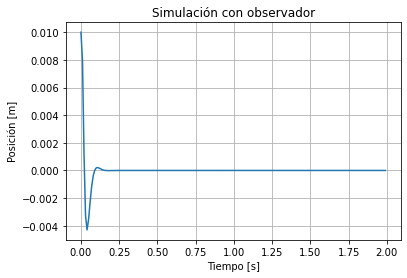

In [23]:
sys_tot = ctrl.ss(At,Bt,Ct,0);

t_tot,y_tot,x_tot =ctrl.forced_response(sys_tot,U=np.zeros(t.size),T=t,X0=np.hstack((x0,x0)),return_x=True)

plt.plot(t_tot,y_tot)
plt.grid()
plt.title('Simulación con observador')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [m]');

Si comparamos con los resultados obtenidos antes, podesmos notar una degradación en la performance del sistema, esto esta relacionado con las condiciones iniciales del estimador y su dinámica; puede ser resuelto ajustando el estimador:

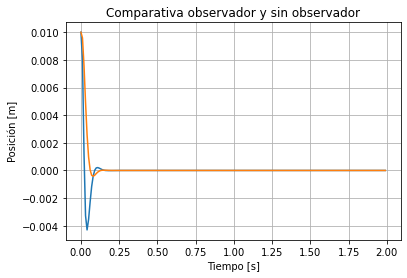

In [24]:
plt.plot(t_tot,y_tot,t2,y2)
plt.grid()
plt.title('Comparativa observador y sin observador')
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [m]');

La evolución de todos los estados es graficada abajo. A partir de $\mathbf{x}$ y $\tilde{\mathbf{x}}$; para obtener $\hat{\mathbf{x}}$, necesitamos calcular $\mathbf{x} - \tilde{\mathbf{x}}$.

In [25]:
t = np.arange(0,.1,1E-6);
x0 = [0.01,0.5,-5];

t_tot2,y_tot2,x_tot2 =ctrl.forced_response(sys_tot,U=np.zeros(t.size),T=t,X0=np.hstack((x0,x0)),return_x=True)

x = x_tot2[0:3,:]
e_est = x_tot2[3:,:]
x_est = x - e_est;

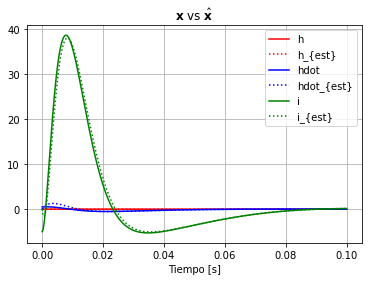

In [26]:
plt.plot(t,x[0,:],
         '-r',t,x_est[0,:],':r',t,x[1,:],
         '-b',t,x_est[1,:],':b',t,x[2,:],
         '-g',t,x_est[2,:],':g')

plt.title(r'$\mathbf{x}$ vs $\hat{\mathbf{x}}$')
plt.legend(['h','h_{est}','hdot','hdot_{est}','i','i_{est}'])
plt.grid()
plt.xlabel('Tiempo [s]');

Graficamos los primeros puntos para ver mejor el instante inicial

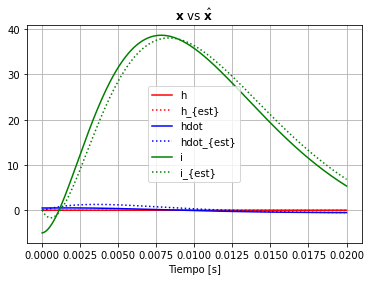

In [27]:
plt.plot(t[0:20000],x[0,0:20000],
         '-r',t[0:20000],x_est[0,0:20000],':r',t[0:20000],x[1,0:20000],
         '-b',t[0:20000],x_est[1,0:20000],':b',t[0:20000],x[2,0:20000],
         '-g',t[0:20000],x_est[2,0:20000],':g')

plt.title(r'$\mathbf{x}$ vs $\hat{\mathbf{x}}$')
plt.legend(['h','h_{est}','hdot','hdot_{est}','i','i_{est}'])
plt.grid()
plt.xlabel('Tiempo [s]');

<a id="id7"></a>    
## Citas y Referencias:

<div class="alert alert-block alert-info">
<b></b> Por ahora dejo las citas y referencia con este formato, si encuentro algo mejor lo cambio.
</div>


___
<a id="cite1"></a>
**REF#1: Control Tutorials for Matlab & Simulink**.

title = Introduction: State-Space Methods for Controller Design.   
url = https://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=ControlStateSpace    
note = Accessed: 2022-04-18   

___
<a id="cite2"></a>
**REF#2: Apuntes de Control Clásico y Variables de Estado**   

autor = Molina, Gonzalo  
url = https://gonmolina.github.io/CCyVE_book/sources/notebooks_sources/modulo1/linealizacion/linealizacion.html   
note = Accessed: 2022-04-18    

___ 
<a id="cite3"></a>    
**REF#3: Multivariable Feedback Control: Analysis and Design**

author = Skogestad, Sigurd and Postlethwaite, Ian   
year = 2005   
isbn = 0470011688   
publisher = John Wiley &amp; Sons, Inc.   
address = Hoboken, NJ, USA   

___

    
<!--bibtex
@misc{ctms,
  title = {{Control Tutorials for Matlab & Simulink} Introduction: State-Space Methods for Controller Design},
  howpublished = {\url{https://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=ControlStateSpace}},
  note = {Accessed: 2022-04-18}
  

@misc{CCyVE,
  title = {{Apuntes de Control Clásico y Variables de Estado} Linealización},
  author = {Molina, Gonzalo},
  howpublished = \url{https://gonmolina.github.io/CCyVE_book/sources/notebooks_sources/modulo1/linealizacion/linealizacion.html}},
  note = {Accessed: 2022-04-18}
  

 @book{10.5555/1121635,
    author = {Skogestad, Sigurd and Postlethwaite, Ian},
    title = {Multivariable Feedback Control: Analysis and Design},
    year = {2005},
    isbn = {0470011688},
    publisher = {John Wiley &amp; Sons, Inc.},
    address = {Hoboken, NJ, USA}
    }
 -->

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />Esta obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Licencia Creative Commons Atribución 4.0 Internacional</a>.